In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from torch import optim

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import time, os

from sklearn.svm import LinearSVC

%matplotlib inline

In [2]:
args = {
    'epoch_num': 5,
    'lr': 1e-3,
    'weight_decay': 8e-4,
    'batch_size': 20,
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


In [3]:
data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_set = datasets.CIFAR10('.',
    train=True,
    transform= data_transform,
    download=True)

test_set = datasets.CIFAR10('.',
    train=False,
    transform= data_transform,
    download=False)

100%|██████████| 170M/170M [00:02<00:00, 59.2MB/s]


Extracting ./cifar-10-python.tar.gz to .


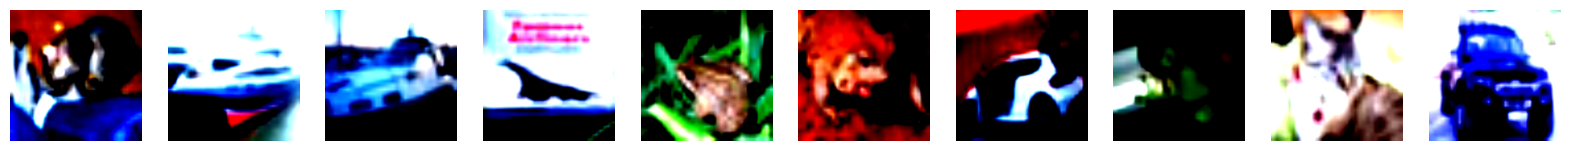

In [4]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    data, label = test_set[i]
    axs[i].imshow(data.permute((1, 2, 0)))
    axs[i].axis('off')

In [5]:
train_loader = DataLoader(train_set,
                          batch_size=args['batch_size'],
                          shuffle=True)

test_loader = DataLoader(test_set,
                         batch_size=args['batch_size'],
                         shuffle=True)

In [6]:
net = models.vgg16_bn(pretrained=True)
print(net)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:03<00:00, 142MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [7]:
novo_classifier = list(net.children())[-1][:-3]

In [8]:
net.classifier = nn.Sequential( * novo_classifier)
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [9]:
def extrai_caracteristicas(net, loader):

    # Evaluation mode
    net.eval()

    feat_list, rotulo_list = [], []
    with torch.no_grad():
        for k, batch in enumerate(loader):
            print('\\r--{0}/{1}--'.format(k, len(loader)), end='', flush=True)

            dado, rotulo = batch

            # Cast do dado na GPU
            dado = dado.to(args['device'])
            rotulo = rotulo.to(args['device'])

            # Extração
            caracteristica = net(dado)
            feat_list.append(caracteristica.detach().cpu().numpy())
            rotulo_list.append(rotulo.detach().cpu().numpy())

    feat_list = np.asarray(feat_list)
    feat_list = np.reshape(feat_list, (feat_list.shape[0]*feat_list.shape[1], feat_list.shape[2]))

    rotulo_list = np.asarray(rotulo_list).ravel()

    return feat_list, rotulo_list

In [ ]:
print('Load train')
train_X, train_Y = extrai_caracteristicas(net, train_loader)
print('\\nLoad test')
test_X, test_Y = extrai_caracteristicas(net, test_loader)

In [ ]:
clf = LinearSVC()
clf.fit(train_X, train_Y)

y_pred = clf.predict(test_X)
print(f'{accuracy_score(test_Y, y_pred) * 100}')

---

In [12]:
net = models.vgg16_bn(pretrained=True)
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [15]:
entrada = list(net.children())[-1][-1].in_features

In [16]:
meu_clf = list(net.classifier.children())[:-1]
meu_clf.append(nn.Linear(entrada, 10))
print(meu_clf)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [17]:
net.classifier = nn.Sequential(*meu_clf)
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [18]:
optimizer= optim.Adam([
    {'params': net.features.parameters(), 'lr': args['lr']*0.2, 'weight_decay': args['weight_decay']*0.2},
    {'params': net.classifier.parameters(), 'lr': args['lr'], 'weight_decay': args['weight_decay']}
], lr=0)

In [19]:
criterion = nn.CrossEntropyLoss().to(args['device'])

In [20]:
def train(train_loader, net, epoch):

  # Training mode
  net.train()

  start = time.time()

  epoch_loss  = []
  pred_list, rotulo_list = [], []
  for batch in train_loader:

    dado, rotulo = batch

    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)

    _, pred = torch.max(ypred, axis=1)
    pred_list.append(pred.cpu().numpy())
    rotulo_list.append(rotulo.cpu().numpy())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)

  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))

  return epoch_loss.mean()

In [21]:
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()

  start = time.time()

  epoch_loss  = []
  pred_list, rotulo_list = [], []
  with torch.no_grad():
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

      _, pred = torch.max(ypred, axis=1)
      pred_list.append(pred.cpu().numpy())
      rotulo_list.append(rotulo.cpu().numpy())

  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)

  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))

  return epoch_loss.mean()

In [ ]:
train_losses, test_losses = [], []
for epoch in range(args['epoch_num']):

  # Train
  train_losses.append(train(train_loader, net, epoch))

  # Validate
  test_losses.append(validate(test_loader, net, epoch))